In [1]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 25,10;
sns.set_context('poster',font_scale=1.4);
import pandas as pd;
from collections import namedtuple
from pprint import pprint;
import sys;
from copy import deepcopy;
import pickle;
import pyccl as ccl
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
%reload_ext autoreload
%autoreload 2
from fisher import Fisher, FullPlot, marginalize, plot_contours

Populating the interactive namespace from numpy and matplotlib


In [2]:
cosmo = ccl.Cosmology(Omega_c=0.2666, 
                       Omega_b=0.049, 
                       h=0.6727, 
                       sigma8=0.831, 
                       n_s=0.9645, 
                       transfer_function='eisenstein_hu')
obj = Fisher(cosmo)


In [4]:
obj._makeSourcePZ()

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


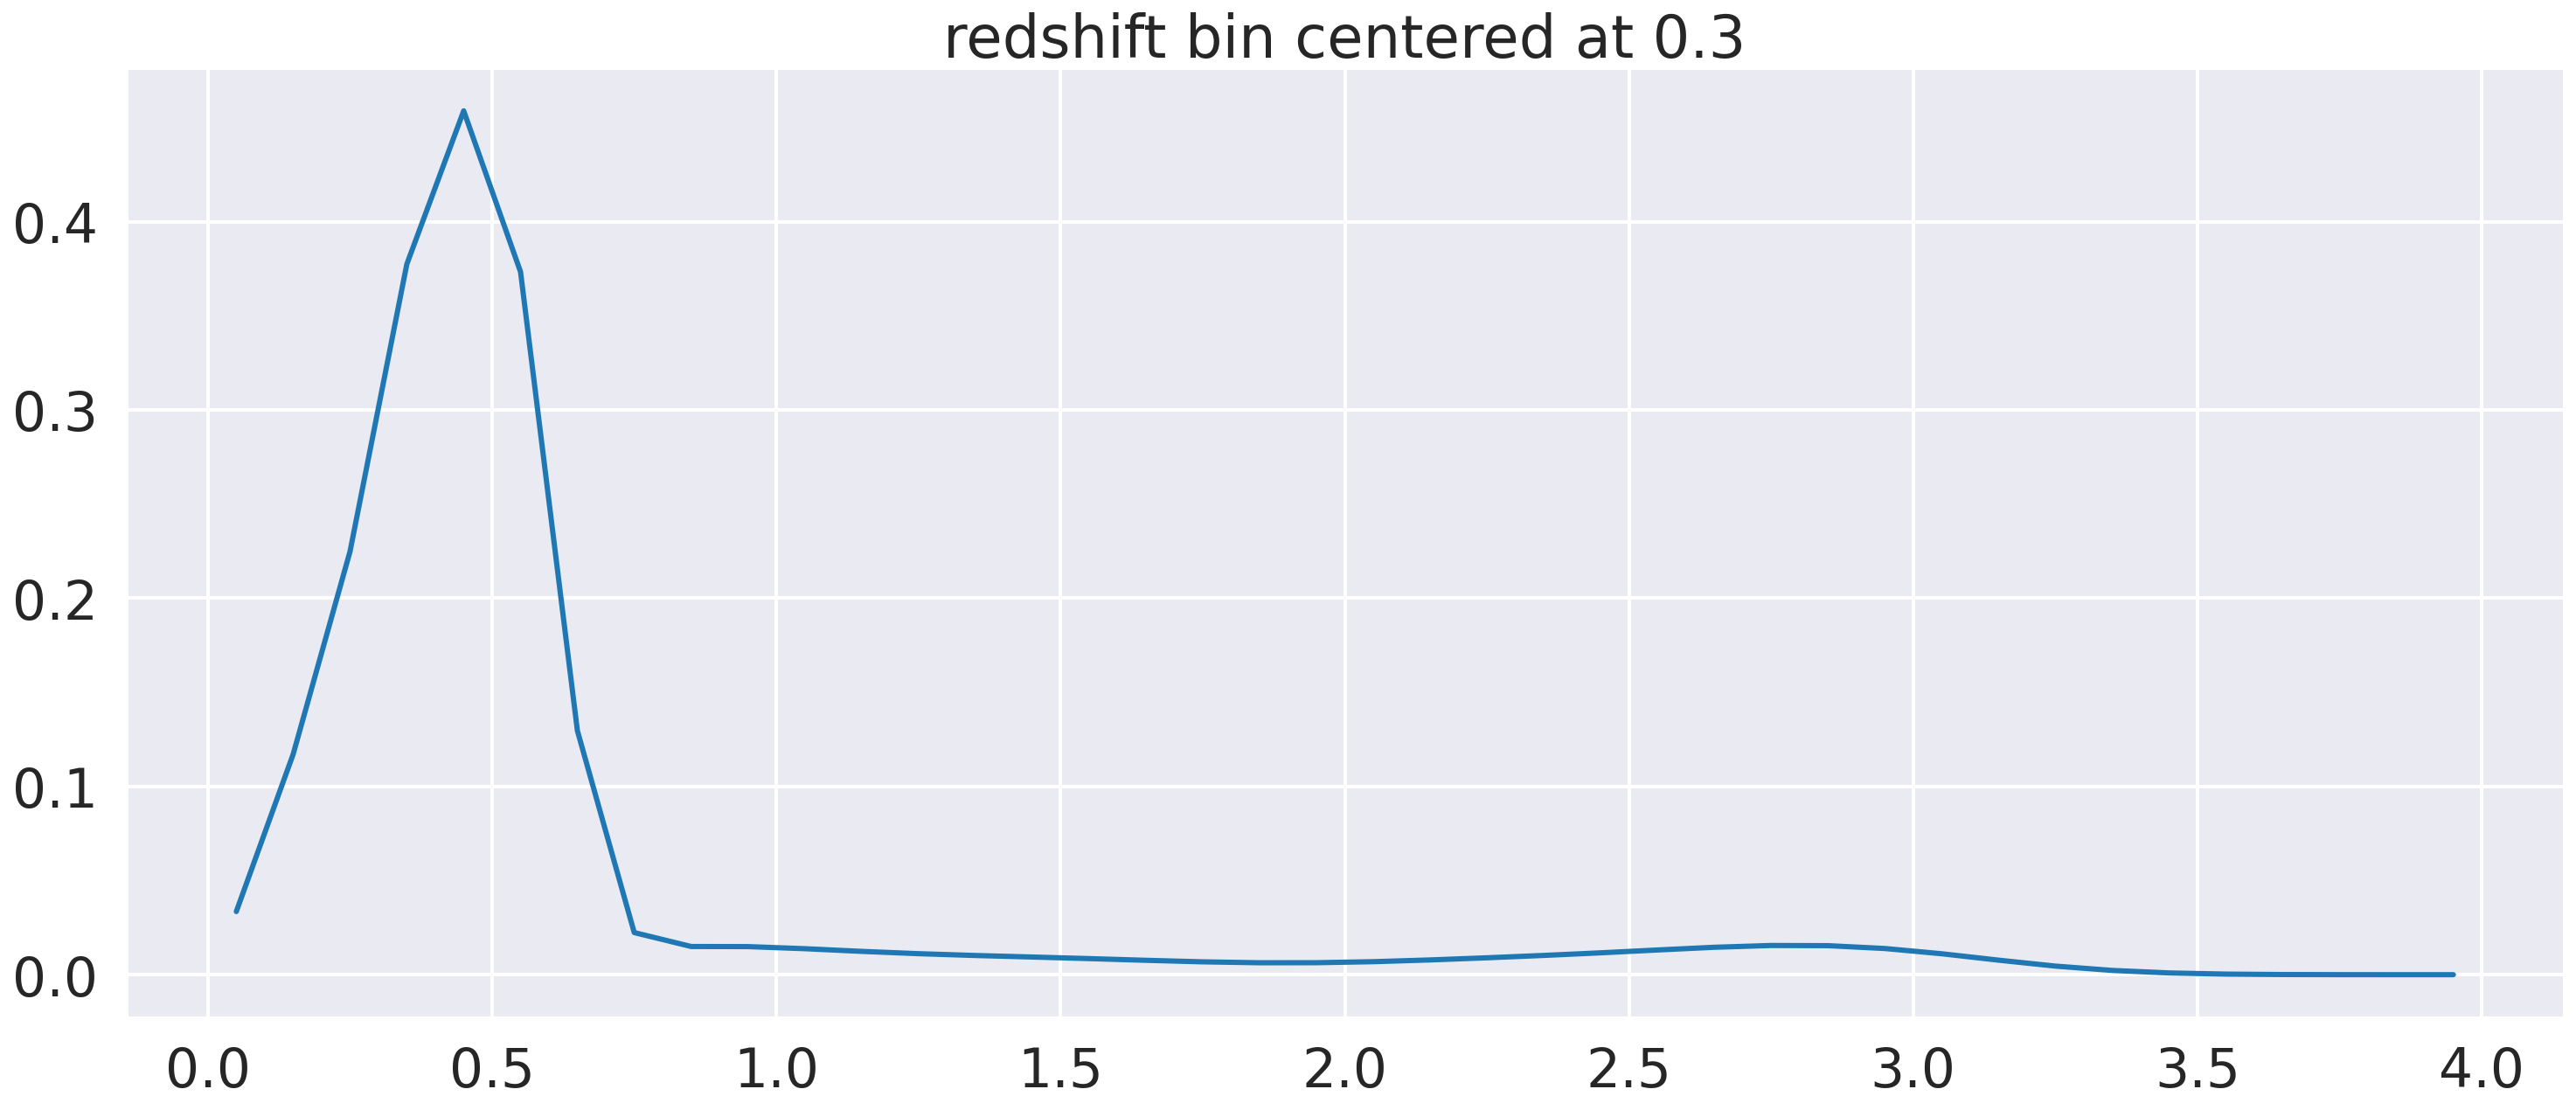

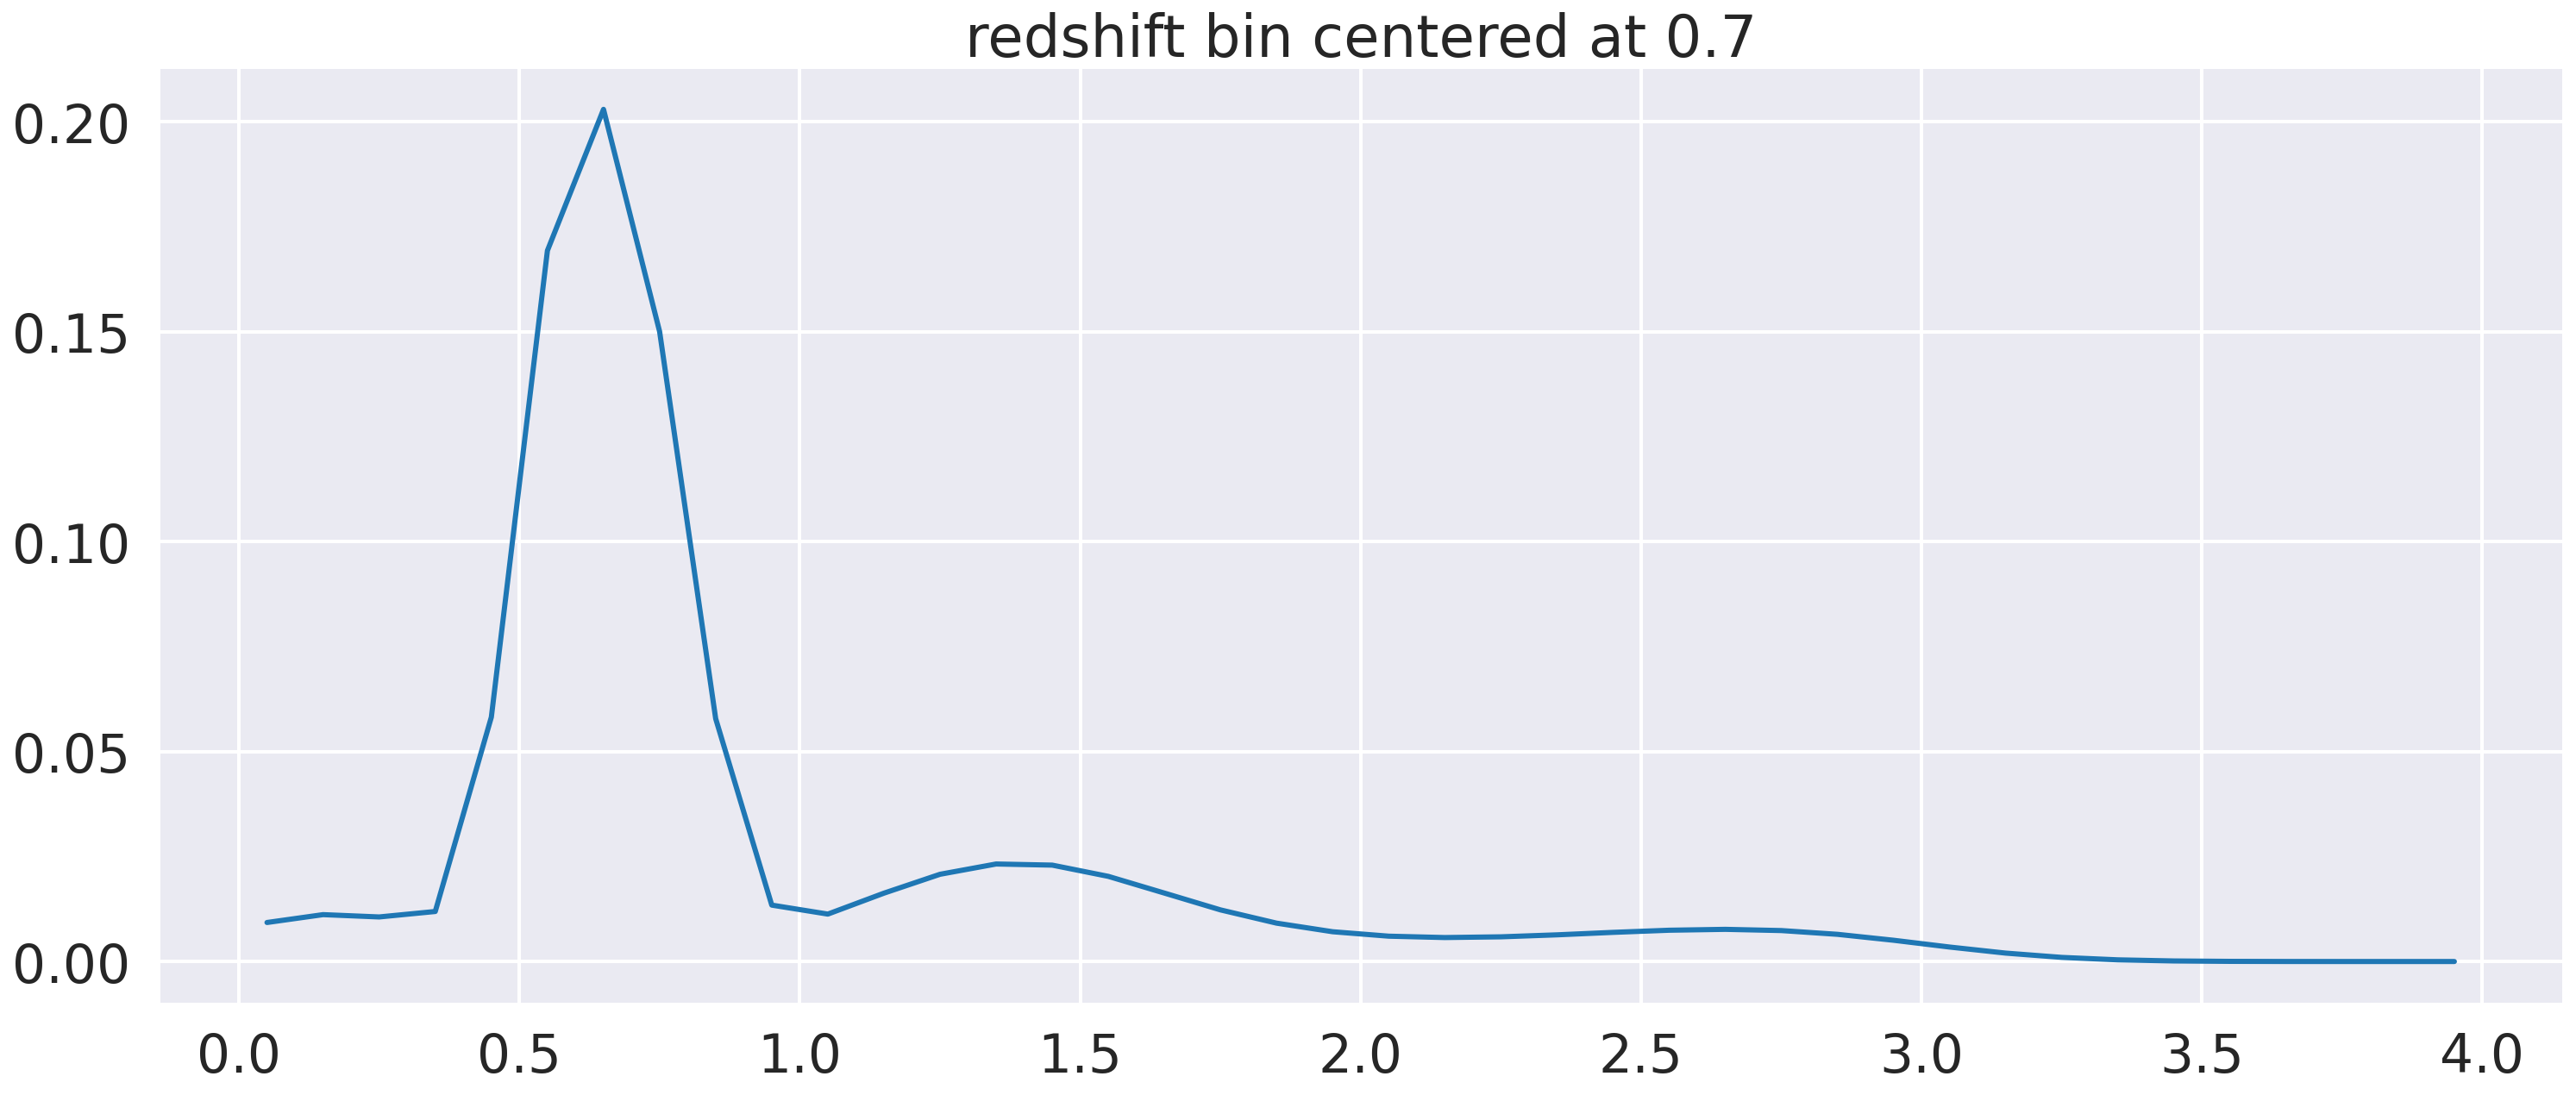

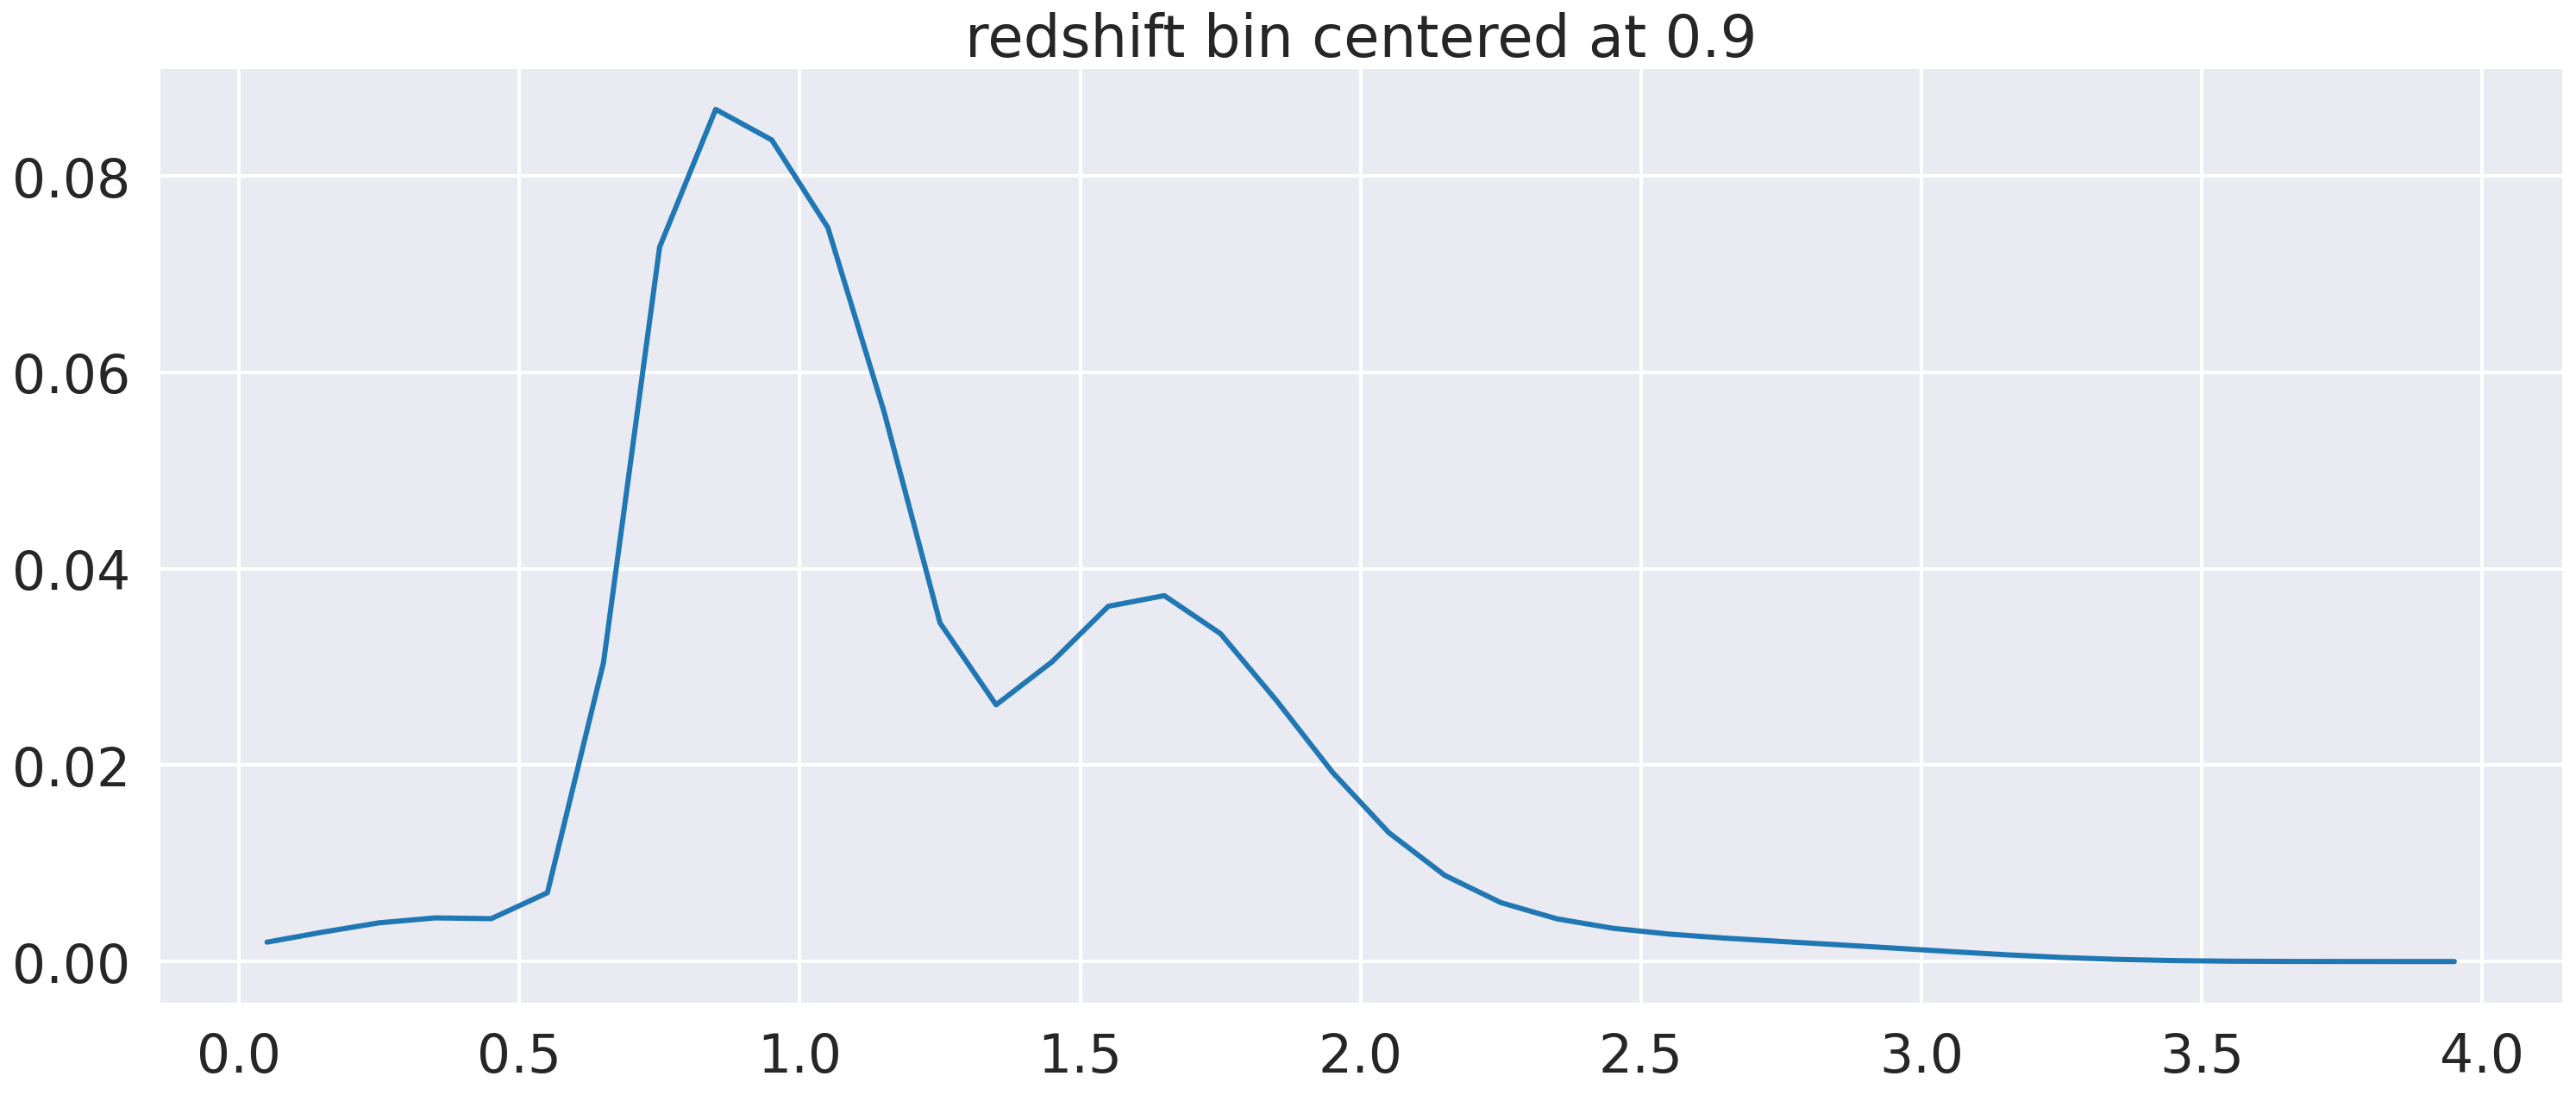

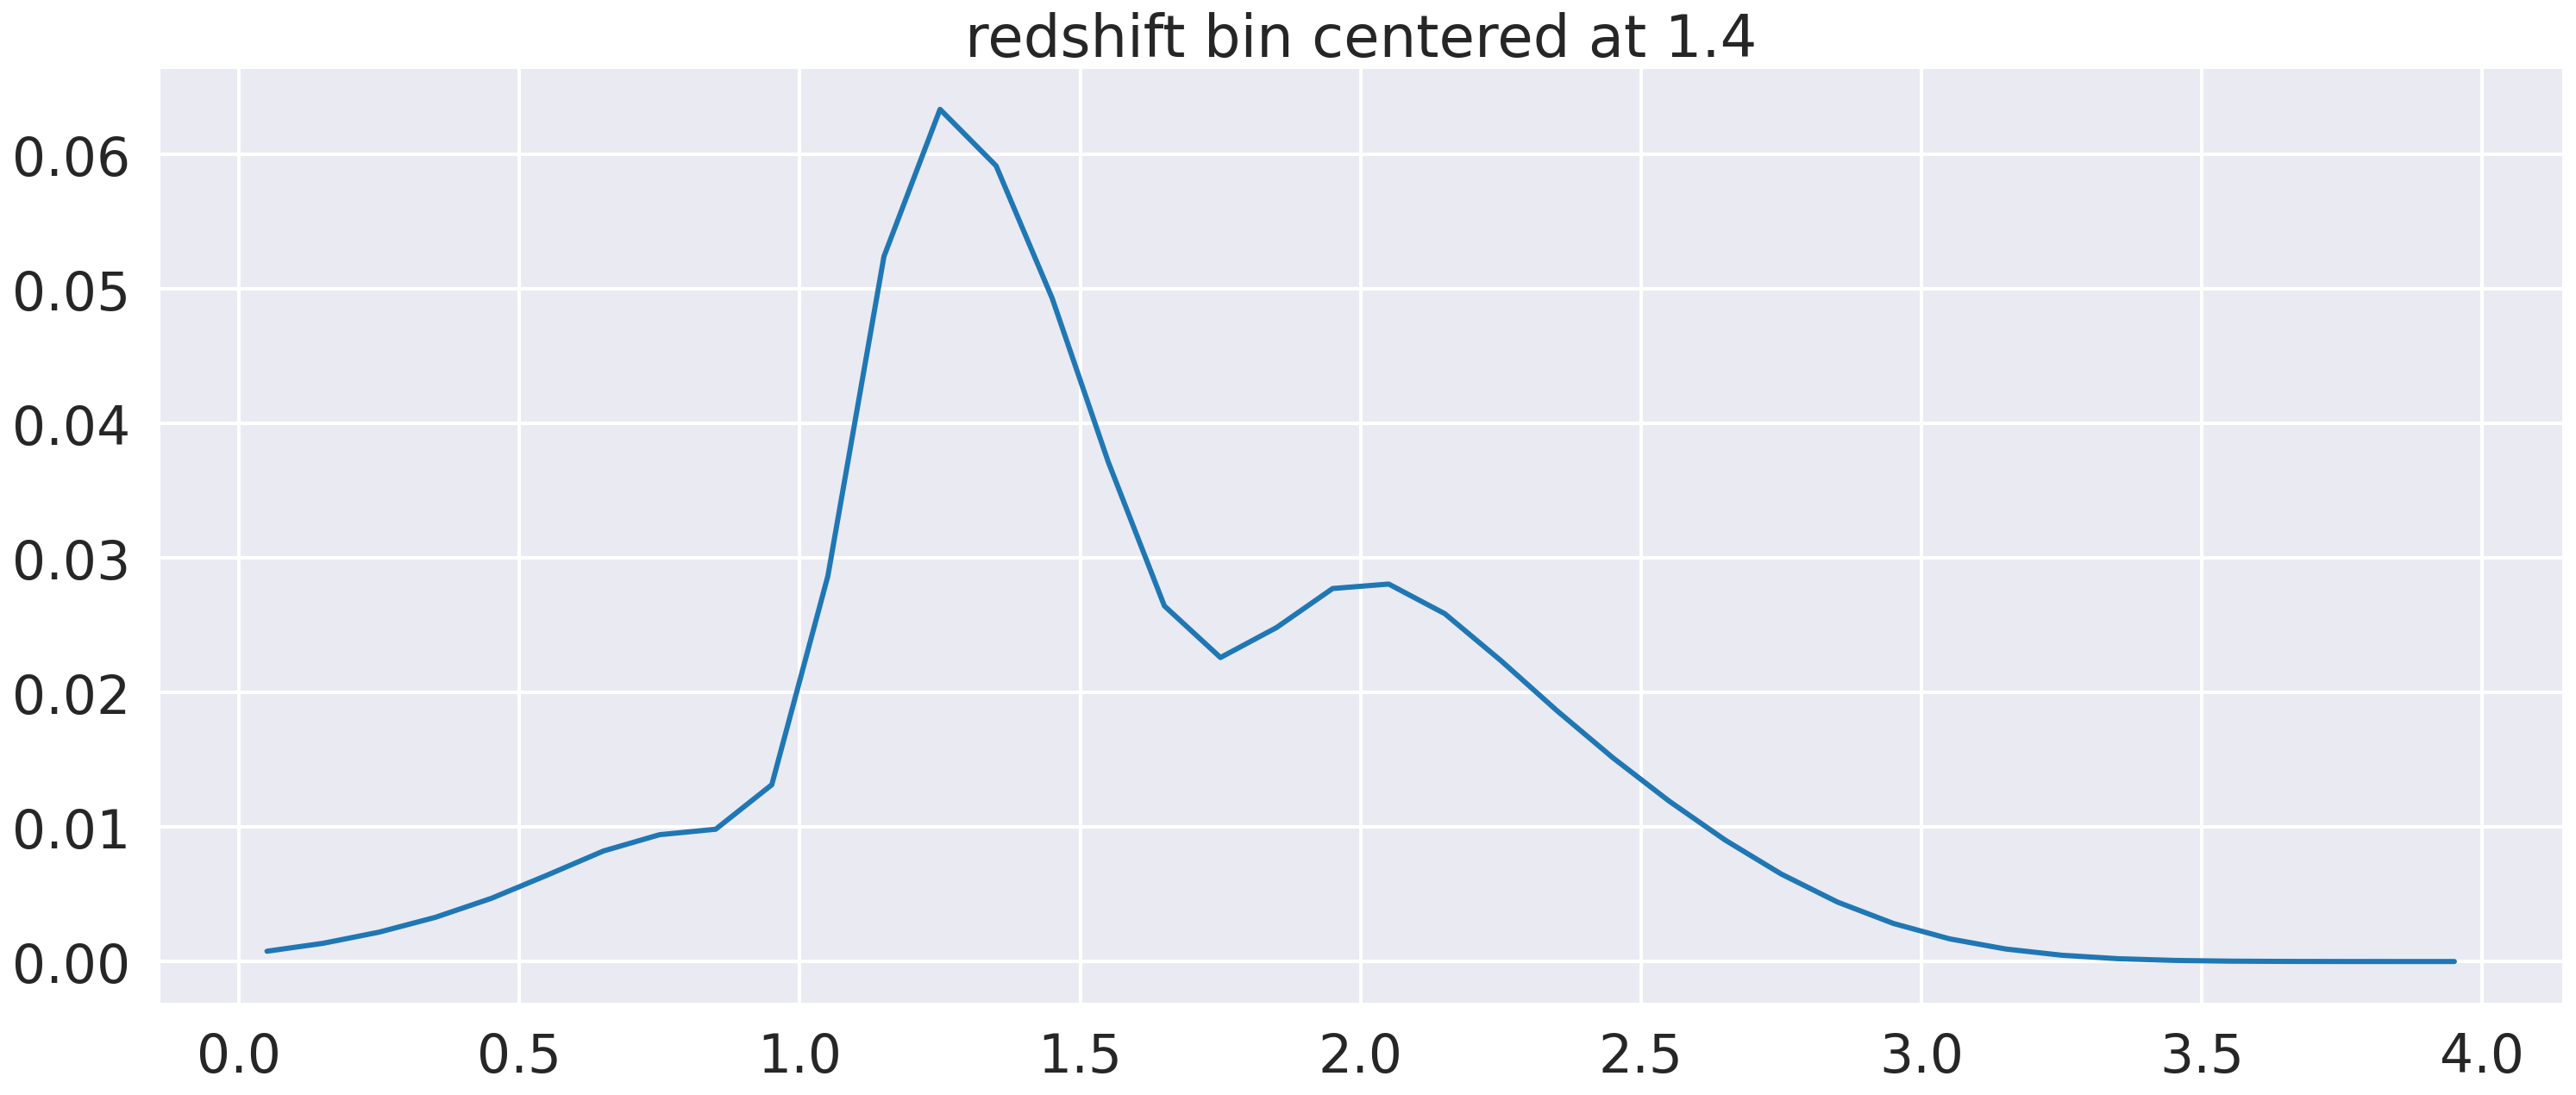

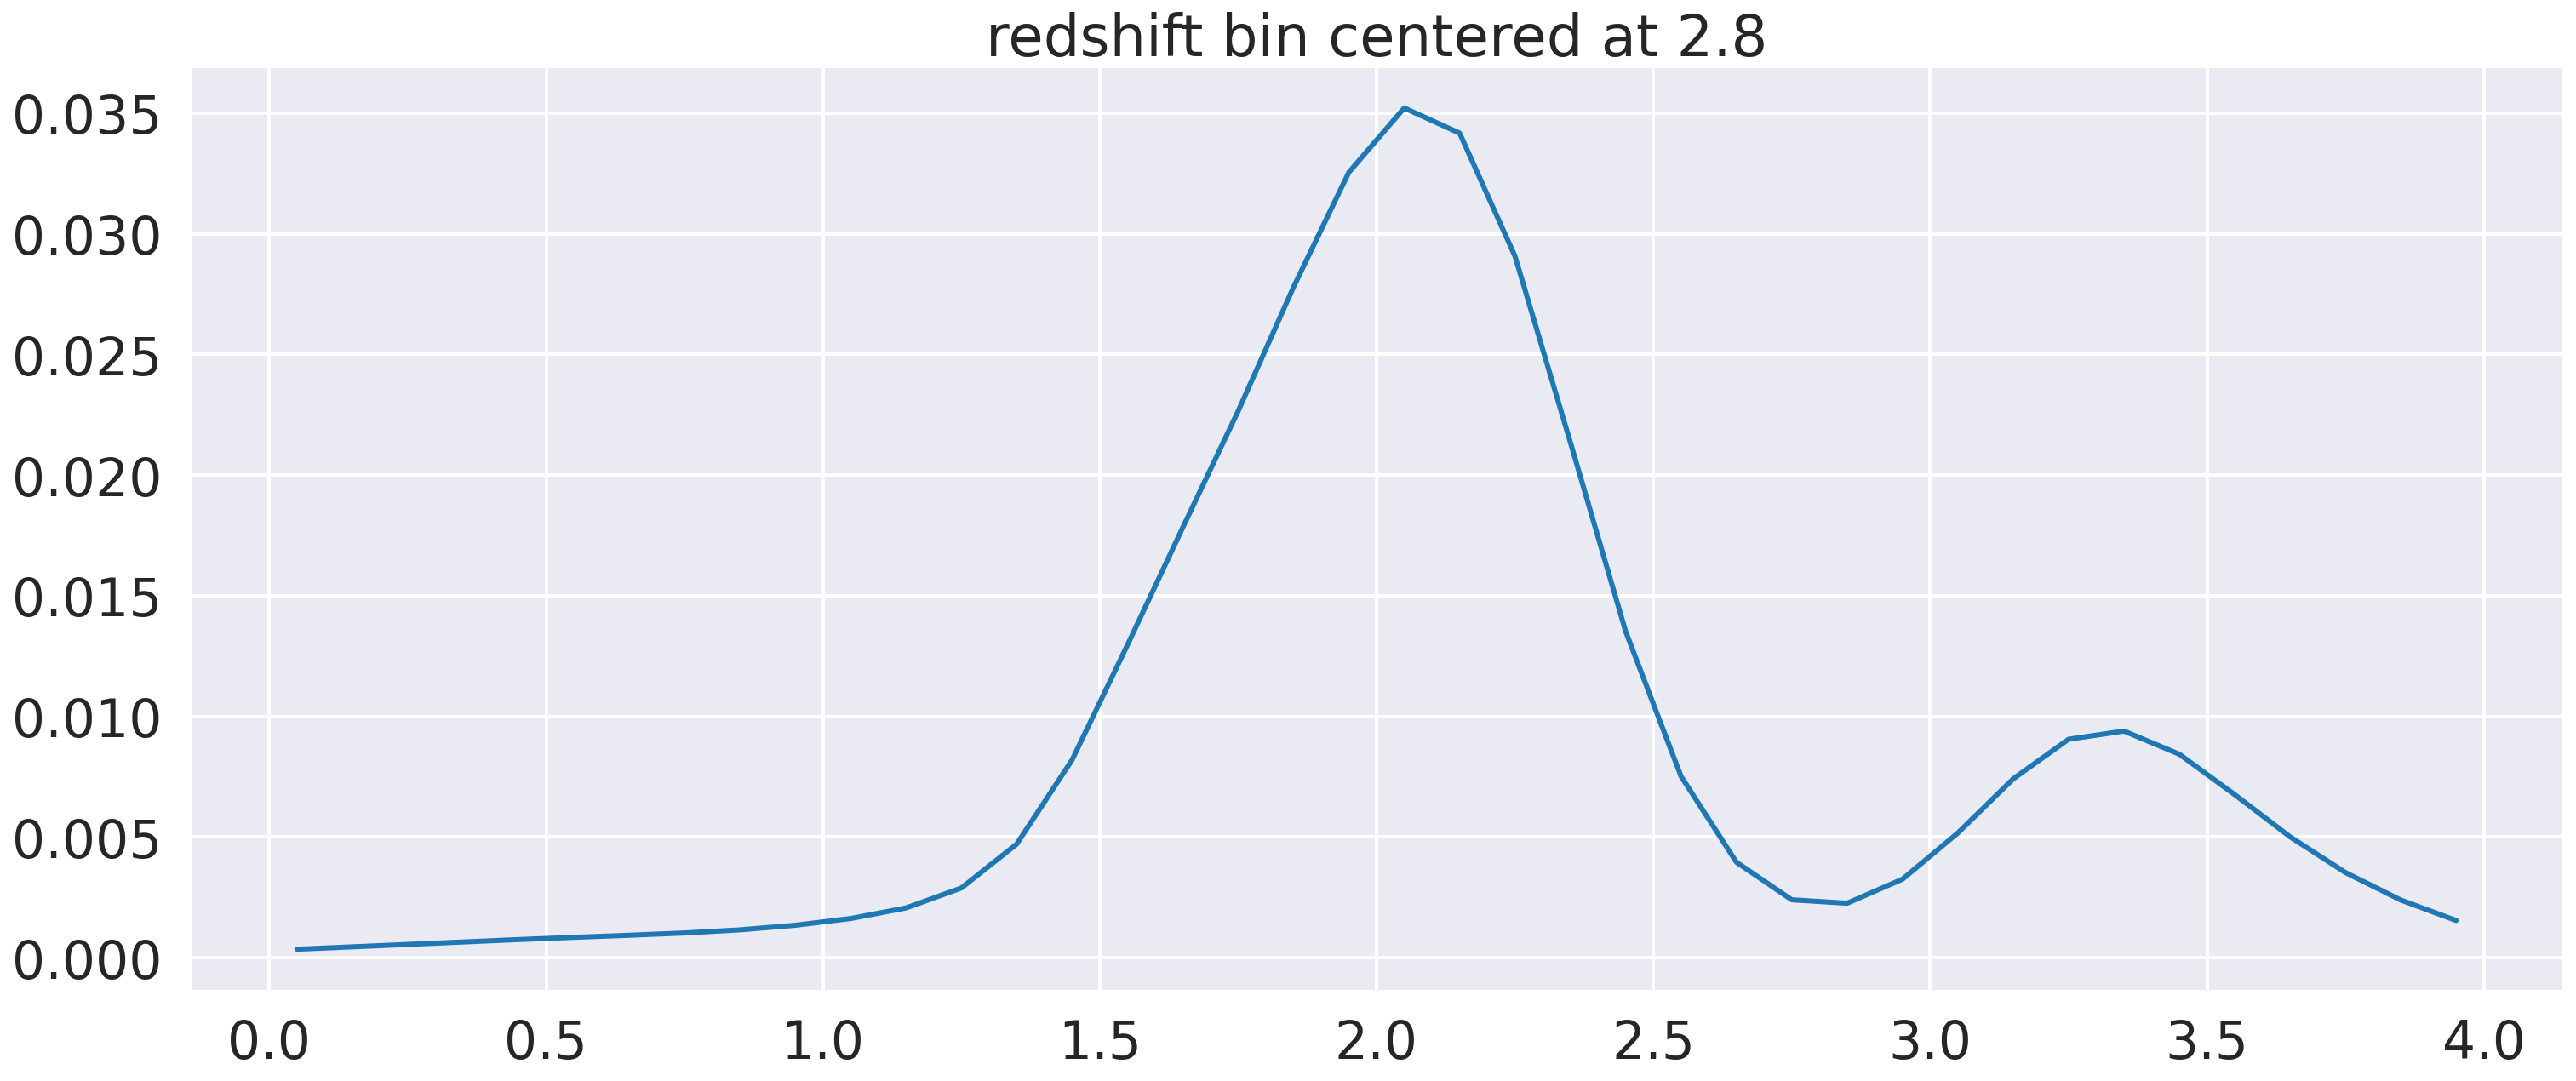

In [7]:
for key in obj.dNdz_dict_source.keys():
    plt.figure()
    _ = sns.lineplot(x=obj.zmid, y=obj.dNdz_dict_source[key], markers=False)
    plt.title(f'redshift bin centered at {key:.1f}')